Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 320, 320, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 320, 320, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 160, 160, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

<ipython-input-3-190b959a9781>:126: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_result = np.mean([structural_similarity(train_high_data[i], train_predictions[i], multichannel=True) for i in range(len(train_high_data))])


Training dataset evaluation:
MSE: 0.048033080995082855
PSNR: 13.18459559899619
MAE: 0.1820482462644577
SSIM: 0.6309363842010498
4/4 [==============================] - 26s 6s/step
Predicted images saved in /content/test/predictedunet


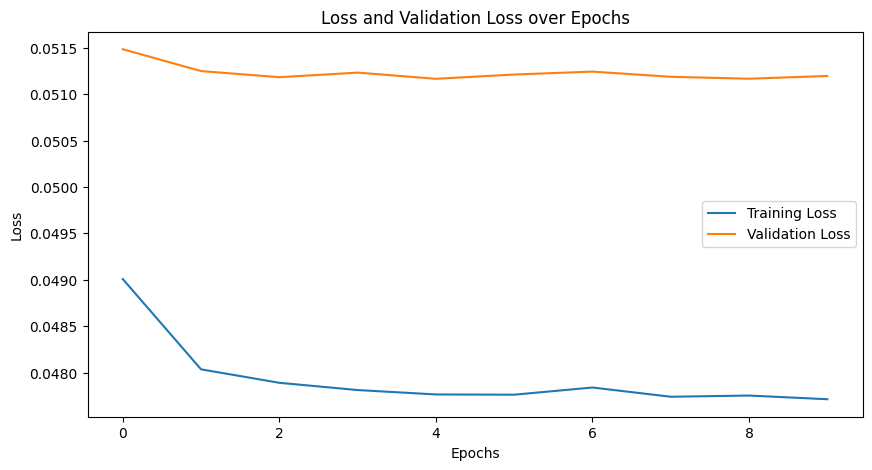

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import tensorflow as tf

# Constants and configurations
SIZE = 320
TRAIN_LOW_DIR = '/content/train/low'
TRAIN_HIGH_DIR = '/content/train/high'
TEST_LOW_DIR = '/content/test/low'
PREDICTED_DIR = '/content/test/predictedunet'
MODEL_PATH = 'denoiser_unet.model'

# Function to load and preprocess images
def load_data(directory):
    data = []
    files = os.listdir(directory)
    for file in files:
        img = cv2.imread(os.path.join(directory, file), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        data.append(img_to_array(img))
    data = np.array(data)
    data = data.astype('float32') / 255.
    return data

# Load training data
train_low_data = load_data(TRAIN_LOW_DIR)
train_high_data = load_data(TRAIN_HIGH_DIR)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Define U-Net model
def build_unet(input_shape, start_neurons):
    input_layer = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation='relu', padding='same')(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation='relu', padding='same')(convm)

    # Decoder
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation='relu', padding='same')(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding='same')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation='relu', padding='same')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation='relu', padding='same')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding='same')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding='same')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding='same')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding='same')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation='relu', padding='same')(uconv1)

    output_layer = Conv2D(3, (1, 1), padding='same', activation='sigmoid')(uconv1)

    return Model(inputs=input_layer, outputs=output_layer)

# Build and compile the model
unet_model = build_unet((SIZE, SIZE, 3), 16)
unet_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
unet_model.summary()

# Train the model
history = unet_model.fit(train_low_data, train_high_data,
                         epochs=10,
                         batch_size=32,
                         shuffle=True,
                         validation_split=0.1)

# Evaluate on training dataset
train_predictions = unet_model.predict(train_low_data)
mse = MeanSquaredError()
mse.update_state(train_high_data, train_predictions)
mse_result = mse.result().numpy()
psnr_result = peak_signal_noise_ratio(train_high_data, train_predictions)
mae = MeanAbsoluteError()
mae.update_state(train_high_data, train_predictions)
mae_result = mae.result().numpy()
ssim_result = np.mean([structural_similarity(train_high_data[i], train_predictions[i], multichannel=True) for i in range(len(train_high_data))])

print(f"Training dataset evaluation:")
print(f"MSE: {mse_result}")
print(f"PSNR: {psnr_result}")
print(f"MAE: {mae_result}")
print(f"SSIM: {ssim_result}")

# Save the trained model
unet_model.save(MODEL_PATH)

# Function to load test data and predict
def predict_on_test(model, test_directory, output_directory):
    test_data = load_data(test_directory)
    predictions = model.predict(test_data)
    os.makedirs(output_directory, exist_ok=True)
    for idx, image in enumerate(predictions):
        plt.imsave(os.path.join(output_directory, f'predicted_image_{idx}.png'), image)

# Predict on test data and save predicted images
predict_on_test(unet_model, TEST_LOW_DIR, PREDICTED_DIR)

print(f"Predicted images saved in {PREDICTED_DIR}")

# Plot loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [2]:
import os
import random
import shutil

# Define paths
original_low_dir = '/content/drive/MyDrive/low'
original_high_dir = '/content/drive/MyDrive/high'
train_low_dir = 'train/low'
train_high_dir = 'train/high'
test_low_dir = 'test/low'
test_high_dir = 'test/high'

# Create directories if they don't exist
os.makedirs(train_low_dir, exist_ok=True)
os.makedirs(train_high_dir, exist_ok=True)
os.makedirs(test_low_dir, exist_ok=True)
os.makedirs(test_high_dir, exist_ok=True)

# Get list of image files
low_images = [f for f in os.listdir(original_low_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
high_images = [f for f in os.listdir(original_high_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

# Ensure the lists are the same length
assert len(low_images) == len(high_images), "Mismatch between low and high images count"

# Shuffle the images
combined = list(zip(low_images, high_images))
random.shuffle(combined)
low_images[:], high_images[:] = zip(*combined)

# Split the images
split_index = int(0.8 * len(low_images))
train_low_images = low_images[:split_index]
test_low_images = low_images[split_index:]
train_high_images = high_images[:split_index]
test_high_images = high_images[split_index:]

# Function to copy images to the respective directories
def copy_images(image_list, source_dir, dest_dir):
    for img_name in image_list:
        shutil.copy(os.path.join(source_dir, img_name), os.path.join(dest_dir, img_name))

# Copy images to train and test directories
copy_images(train_low_images, original_low_dir, train_low_dir)
copy_images(test_low_images, original_low_dir, test_low_dir)
copy_images(train_high_images, original_high_dir, train_high_dir)
copy_images(test_high_images, original_high_dir, test_high_dir)

print("Dataset split completed successfully!")

Dataset split completed successfully!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import tensorflow as tf

# Constants and configurations
SIZE = 320
TRAIN_LOW_DIR = '/content/train/low'
TRAIN_HIGH_DIR = '/content/train/high'
TEST_LOW_DIR = '/content/test/low'
PREDICTED_DIR = '/content/test/predicted'
MODEL_PATH = 'denoising_autoencoder.model'

# Function to load and preprocess images
def load_data(directory):
    data = []
    files = os.listdir(directory)
    for file in files:
        img = cv2.imread(os.path.join(directory, file), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        data.append(img_to_array(img))
    data = np.array(data)
    data = data.astype('float32') / 255.
    return data

# Apply NLM filtering
def apply_nlm_filtering(data):
    filtered_data = []
    for img in data:
        img = img * 255.0  # Convert back to original scale
        img = cv2.fastNlMeansDenoisingColored(np.uint8(img), None, 10, 10, 7, 21)
        img = img_to_array(img) / 255.0  # Normalize back to [0, 1]
        filtered_data.append(img)
    return np.array(filtered_data)

# Load and preprocess training data
train_low_data = load_data(TRAIN_LOW_DIR)
train_high_data = load_data(TRAIN_HIGH_DIR)
train_low_data_filtered = apply_nlm_filtering(train_low_data)

# Define data augmentation generator
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=90,
                     zoom_range=0.2,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(train_low_data_filtered)
image_datagen.fit(train_high_data)

train_generator = image_datagen.flow(train_low_data_filtered, train_high_data, batch_size=32)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Define the autoencoder model
def build_modified_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2), padding='same')(conv3)
    pool3 = Dropout(0.5)(pool3)

    # Bottleneck
    convm = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    convm = Conv2D(512, (3, 3), activation='relu', padding='same')(convm)

    # Decoder
    up3 = UpSampling2D((2, 2))(convm)
    deconv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(up3)
    deconv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(deconv3)

    up2 = UpSampling2D((2, 2))(deconv3)
    deconv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    deconv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(deconv2)

    up1 = UpSampling2D((2, 2))(deconv2)
    deconv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    deconv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(deconv1)

    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(deconv1)

    return Model(inputs=input_layer, outputs=output_layer)

model = build_modified_autoencoder((SIZE, SIZE, 3))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
model.summary()

# Train the model with a larger number of epochs
history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch=len(train_low_data) // 32,
                    validation_split=0.1)

# Evaluate on training dataset
train_predictions = model.predict(train_low_data_filtered)

# Calculate evaluation metrics
mse = MeanSquaredError()
mae = MeanAbsoluteError()

mse.update_state(train_high_data, train_predictions)
mse_result = mse.result().numpy()

mae.update_state(train_high_data, train_predictions)
mae_result = mae.result().numpy()

psnr_values = [compare_psnr(train_high_data[i], train_predictions[i]) for i in range(len(train_high_data))]
psnr_result = np.mean(psnr_values)

print(f"Training dataset evaluation:")
print(f"MSE: {mse_result}")
print(f"PSNR: {psnr_result}")
print(f"MAE: {mae_result}")

# Save the trained model
model.save(MODEL_PATH)

# Function to load test data and predict
def predict_on_test(model, test_directory, output_directory):
    test_data = load_data(test_directory)
    predictions = model.predict(test_data)
    os.makedirs(output_directory, exist_ok=True)
    for idx, image in enumerate(predictions):
        plt.imsave(os.path.join(output_directory, f'predicted_image_{idx}.png'), image)

# Predict on test data and save predicted images
predict_on_test(model, TEST_LOW_DIR, PREDICTED_DIR)

print(f"Predicted images saved in {PREDICTED_DIR}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


NameError: name 'Adam' is not defined